In [38]:
import matplotlib.pyplot as plt
import random
import math

In [39]:
plt.rcParams['figure.figsize'] = [13, 7]

In [58]:
xmin = 3     # [mm]
xmax = 194   # [mm]
ymin = 3     # [mm]
ymax = 77    # [mm]

angle_step_degrees = 45   # degrees

In [59]:
assert 360 % angle_step_degrees == 0, 'Angle should be a divisor of 360'
angle_step = (2*math.pi / 360 )*angle_step_degrees

In [60]:
def random_line(nr_of_points=2):
    # maximum length (diagonal of the board)
    # start at a random position
    x = [random.uniform(xmin, xmax)]
    y = [random.uniform(ymin, ymax)]
    
    for i in range(nr_of_points):
        # generate angle and length
        angle = random.randint(0,7)*angle_step
        
        # calculate the maximum length in the generated direction
        try:
            l1 = (xmax - x[i])/math.cos(angle)
        except ZeroDivisionError:
            l1 = math.inf
        try:
            l2 = (xmin - x[i])/math.cos(angle)
        except ZeroDivisionError:
            l2 = math.inf
        try:
            l3 = (ymax - y[i])/math.sin(angle)
        except ZeroDivisionError:
            l3 = math.inf
        try:
            l4 = (ymin - y[i])/math.sin(angle)
        except ZeroDivisionError:
            l4 = math.inf
        possible_lenghts = [l1, l2, l3, l4]
        
        # the maximum line is the smallest positive length
        max_length = min([l for l in possible_lenghts if l >= 0])
        length = random.uniform(0,max_length)
        
        x.append(x[i] + math.cos(angle)*length)
        y.append(y[i] + math.sin(angle)*length)
        
    return x, y

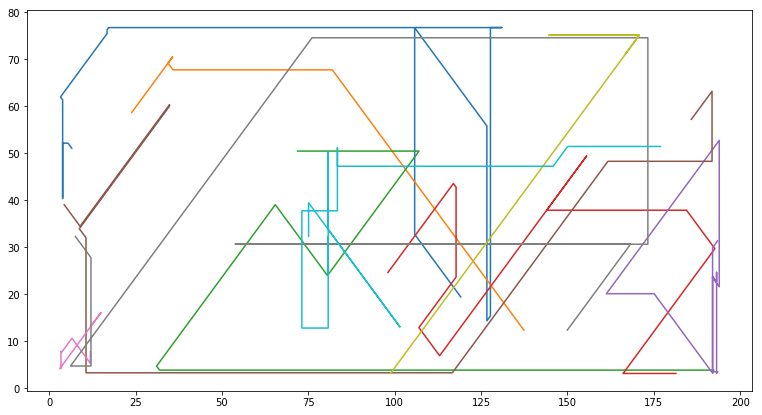

In [61]:
for i in range(10):
    nr_of_points = random.randint(2,20)
    x,y = random_line(nr_of_points)
    plt.plot(x,y)
plt.show()

The lines in the exported file look like this

    (Line
        (Connect1 -1)
        (ConnectL1 -1)
        (ConnectP1 -1)
        (Connect2 -1)
        (ConnectP2 -1)
        (ConnectL2 0)
        (ConnectedToLine1 "N")
        (ConnectedToLine2 "N")
        (FreeEnd1 "Y")
        (FreeEnd21 "Y")
        (Selected "N")
        (Group -1)
        (OldNumber 0)
        (PairLine_Link -1)
        (ConnectMode1 -1)
        (ConnectMode2 -1)
        (Points
            (pt 555.842 -149.558 0 1 1.05 0 0 0 "N" "N" -1 0 0 0 "N" -1 0 0 0 "N")

            < ... more of these lines ... >

        )
    )

So it's like an XML file, except normal braces are used instead of angle brackets. The 2nd and 3rd element look like x and y coordinates. The others probably contain some info about the line style and thickness.. we'll figure that out later.

In [30]:
with open('linehead.txt') as f:
    linehead = f.read()
linefoot = '          )\n        )'
def line_from_coordinates(xlist,ylist):
    pointlines = []
    for x,y in zip(xlist, ylist):
        x = 3*x
        y = -3*y
        pointlines.append(f'            (pt {x} {y} 0 1 1.05 0 0 0 "N" "N" -1 0 0 0 "N" -1 0 0 0 "N")')
    return '\n'.join([linehead] + pointlines + [linefoot])

line_from_coordinates([1, 3], [2, 6])

'        (Line\n          (Connect1 -1)\n          (ConnectL1 -1)\n          (ConnectP1 -1)\n          (Connect2 -1)\n          (ConnectP2 -1)\n          (ConnectL2 0)\n          (ConnectedToLine1 "N")\n          (ConnectedToLine2 "N")\n          (FreeEnd1 "Y")\n          (FreeEnd21 "Y")\n          (Selected "N")\n          (Group -1)\n          (OldNumber 0)\n          (PairLine_Link -1)\n          (ConnectMode1 -1)\n          (ConnectMode2 -1)\n          (Points\n            (pt 3 -6 0 1 1.05 0 0 0 "N" "N" -1 0 0 0 "N" -1 0 0 0 "N")\n            (pt 9 -18 0 1 1.05 0 0 0 "N" "N" -1 0 0 0 "N" -1 0 0 0 "N")\n          )\n        )'

I stored the top of the file in 'head.txt' and the bottom in 'foot.txt'. So now we're ready to generate a custom ASCII file.

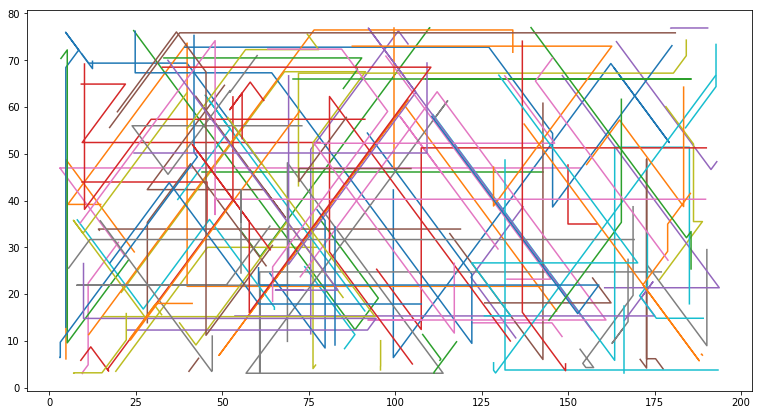

In [31]:
with open('traces_head.txt') as f:
    head = f.read()
with open ('traces_foot.txt') as f:
    foot = f.read()
lines = []
for i in range(100):
    nr_of_points = random.randint(2,5)
    x,y = random_line(nr_of_points)
    lines.append(line_from_coordinates(x,y))
    plt.plot(x,y)
body = '\n'.join(lines)
plt.show()
with open('traces_output.asc', 'w') as f:
    f.write(head)
    f.write(body)
    f.write(foot)

### New approach: generate pads instead of traces

In [32]:
def generate_pad(x, y, padnumber, netnumber):
    with open('component.txt') as f:
        return f.read().format(nr=1, x=3*x, y=-3*y, netnumber=2, othernumber=padnumber)

In [33]:
def generate_net(netnumber):
    with open('net.txt') as f:
        return f.read().format(netnumber=netnumber)

In [34]:
def generate_connection(nr1, nr2):
    with open('connection.txt') as f:
        return f.read().format(nr1=nr1, nr2=nr2)

In [63]:
NR_OF_NETS = 80
NR_OF_PADS_PER_NET = 10

nets = []
components = []
connections = []

for netnumber in range(NR_OF_NETS):
    nets.append(generate_net(netnumber))
    for padnumber in range(NR_OF_PADS_PER_NET):
        x = random.uniform(xmin,xmax)
        y = random.uniform(ymin,ymax)
        components.append(generate_pad(x,y,padnumber,netnumber))
        connections.append(generate_connection(netnumber,netnumber))
          
nets = '\n'.join(nets)
components = '\n'.join(components)
connections = '\n'.join(connections)

with open('skeleton.asc') as infile:
    with open('random_pads.asc','w') as outfile:
        file = infile.read().format(components=components, nets=nets, connections=connections)
        outfile.write(file)